https://drlee.io/market-basket-analysis-with-python-a-beginners-guide-to-apriori-and-mlxtend-c04725aa2c4d



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys 
sys.path.append("../")

from src import soporte_exploracion as se
pd.set_option('display.max_columns', None)


# Análisis exploratorio analítico

In [2]:
# cargamos el conjunto de datos
df = pd.read_excel('../data/retail.xlsx')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [3]:
# hago el analisis exploratorio de datos usando la funcion almacenada en la carpeta de src
se.exploracion_dataframe(df)


El dataframe tiene 525461 filas y 8 columnas.
------------------------------------------------------------
Filas duplicadas: 6865 que corresponde con un 1.31 % del total de los datos
------------------------------------------------------------
Columnas con valores nulos (%):


,%_nulos
Customer ID,20.539488
Description,0.557225


------------------------------------------------------------
Tipos de datos:


,tipo_dato
Invoice,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,datetime64[ns]
Price,float64
Customer ID,float64
Country,object


------------------------------------------------------------
No hay columnas constantes.
------------------------------------------------------------
Columnas categóricas: ['Invoice', 'StockCode', 'Description', 'Country']

INVOICE - valores únicos:


Invoice
537434    675
538071    652
537638    601
537237    597
536876    593
536592    592
537823    591
536031    582
490074    580
491966    579
Name: count, dtype: int64


STOCKCODE - valores únicos:


StockCode
85123A    3516
22423     2221
85099B    2057
21212     1933
21232     1843
20725     1620
84879     1458
84991     1400
21754     1386
20914     1276
Name: count, dtype: int64


DESCRIPTION - valores únicos:


Description
WHITE HANGING HEART T-LIGHT HOLDER    3549
NaN                                   2928
REGENCY CAKESTAND 3 TIER              2212
STRAWBERRY CERAMIC TRINKET BOX        1843
PACK OF 72 RETRO SPOT CAKE CASES      1466
ASSORTED COLOUR BIRD ORNAMENT         1457
60 TEATIME FAIRY CAKE CASES           1400
HOME BUILDING BLOCK WORD              1386
JUMBO BAG RED RETROSPOT               1310
LUNCH BAG RED SPOTTY                  1274
Name: count, dtype: int64


COUNTRY - valores únicos:


Country
United Kingdom     485852
EIRE                 9670
Germany              8129
France               5772
Netherlands          2769
Spain                1278
Switzerland          1187
Portugal             1101
Belgium              1054
Channel Islands       906
Name: count, dtype: int64

------------------------------------------------------------
Estadísticas de columnas numéricas:


,count,mean,std,min,25%,50%,75%,max
Quantity,525461.0,10.337667,107.424110,-9600.00,1.00,3.0,10.00,19152.00
Price,525461.0,4.688834,146.126914,-53594.36,1.25,2.1,4.21,25111.09
Customer ID,417534.0,15360.645478,1680.811316,12346.00,13983.00,15311.0,16799.00,18287.00


------------------------------------------------------------


#### Conclusiones del análisis exploratorio de datos


- El dataset cuenta con más de **525k registros** y **8 columnas**, incluyendo identificadores de factura (`Invoice`) y producto (`StockCode`), esenciales para MBA.

- Se detectaron **filas duplicadas**, que deben eliminarse para evitar inflar la frecuencia de productos en las cestas.

- La variable `Customer ID` tiene más del 20% de valores nulos, pero no es crítica para el análisis de cestas, ya que este se centra en el nivel de factura.

- Algunas transacciones tienen **valores negativos en `Quantity` y `Price`**, probablemente por devoluciones, lo que puede alterar la construcción de las cestas si no se filtran.

- Hay productos con descripciones faltantes y codificaciones que podrían necesitar normalización si se usan como etiquetas.

**Conclusiones clave para el Basket Analysis**

- `Invoice` actúa como identificador de transacción, lo que permite agrupar productos comprados juntos.

- La mayoría de las transacciones provienen del **Reino Unido**, por lo que si se incluyen todos los países, conviene segmentar o normalizar.

- La existencia de devoluciones puede generar transacciones “vacías” o con cantidades negativas si no se trata adecuadamente.

- Algunas facturas aparecen muchas veces, lo que sugiere compras múltiples en una misma sesión (ideal para MBA).



In [6]:
# me doy cuenta de que el value counts de los codigos de productos no coinciden con los de la descripcion. Por lo que algo debe ocurrir.
print(df[df["StockCode"].str.contains("85123", na = False)]["StockCode"].unique())

# al hacer el filtro veo que algunis codigos están en mayuscula y otros en minuscula, por lo que voy a homogeneizarlo
df["StockCode"] = df["StockCode"].str.upper()
df["Description"] = df["Description"].str.upper()

['85123A' '85123b' '85123a']


In [10]:
# voy a filtar el conjunto de datos para eliminar los valores negativos de la columna 'Quantity" y evitar malas interpretaciones en lo que me queda de análisis exploratorio
condicion1 = df["Price"] >= 1
condicion2 = df["Quantity"] >= 0

df = df[condicion1 & condicion2].sort_values(by = "Price")

# Analisis exploratorio visual

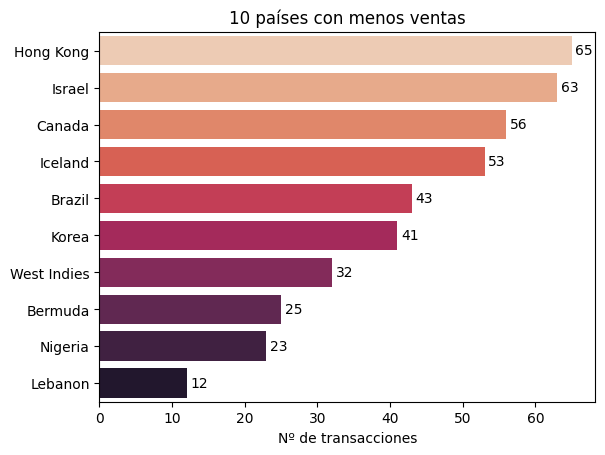

In [11]:
# numero de ventas por pais
df_pais = df.groupby(["Country"])["Invoice"].count().reset_index().sort_values(by = "Invoice", ascending = False)

# ploteamos los 10 paises con menos ventas
sns.barplot(y = "Country", 
            x = "Invoice", 
            data = df_pais.tail(10), 
            palette = "rocket_r", 
            hue = "Country")
plt.title("10 países con menos ventas")
plt.xlabel("Nº de transacciones")
plt.ylabel("")

# Añadir anotaciones a cada barra
for i, (valor, pais) in enumerate(zip(df_pais.tail(10)["Invoice"], df_pais.tail(10)["Country"])):
    plt.text(valor + 0.5,  # un poco a la derecha de la barra
             i,           # posición vertical (índice)
             f"{valor:.0f}",  # el texto a mostrar (sin decimales)
             va='center')     # alineación vertical

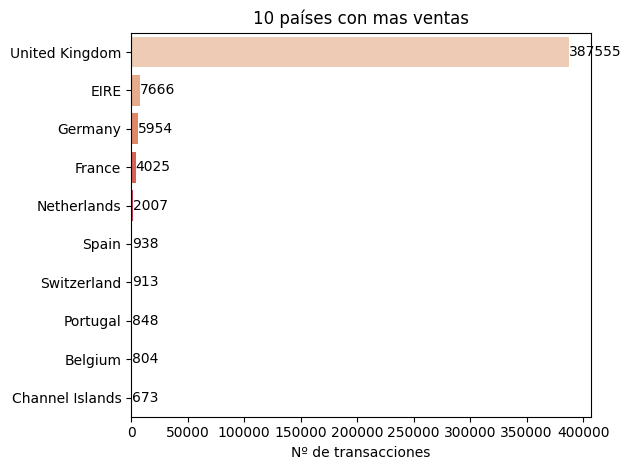

In [12]:
# ploteamos los 10 paises con mas ventas
sns.barplot(y = "Country", 
            x = "Invoice", 
            data = df_pais.head(10),
            palette = "rocket_r", 
            hue = "Country")
plt.title("10 países con mas ventas")
plt.xlabel("Nº de transacciones")
plt.ylabel("")


# Añadir anotaciones a cada barra
for i, (valor, pais) in enumerate(zip(df_pais.head(10)["Invoice"], df_pais.head(10)["Country"])):
    plt.text(valor + 0.5,  # un poco a la derecha de la barra
             i,           # posición vertical (índice)
             f"{valor:.0f}",  # el texto a mostrar (sin decimales)
             va='center')     # alineación vertical

plt.tight_layout()

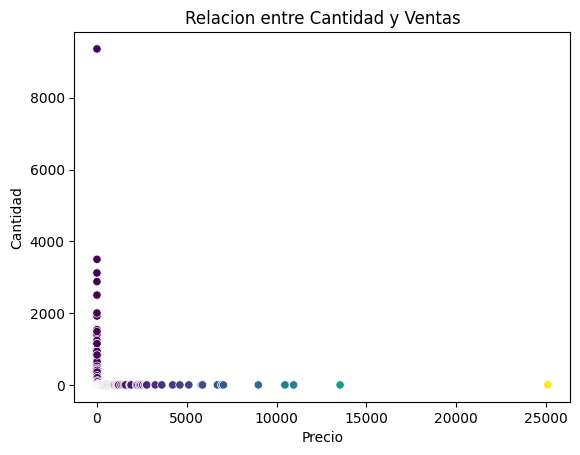

In [13]:
# relacion entre precio y cantidad
sns.scatterplot(x = "Price", 
                y = "Quantity", 
                data = df,
                palette = "viridis", 
                hue = "Price", 
                legend = False)
plt.title("Relacion entre Cantidad y Ventas")
plt.ylabel("Cantidad")
plt.xlabel("Precio");

**Conclusion de la grafica de relacion entre precio y cantidad** 

- **Mayoría de productos**: baratos y con pocas unidades vendidas esto podria sugerir que las reglas de asociación más fuertes saldrán de estos productos.

- **Outliers**: precios muy altos (> 20,000) o cantidades muy grandes (> 9,000) → Considerar eliminarlos o analizarlos aparte (ventas atípicas o mayoristas).

- **No parece que haya una relación clara** entre precio y cantidad → Agrupar productos por categorías puede ser más útil para encontrar patrones.

Por lo tanto, para un análisis efectivo:

- Filtrar *outliers* antes de aplicar reglas de asociación.

- Usar productos comunes y frecuentes como base.


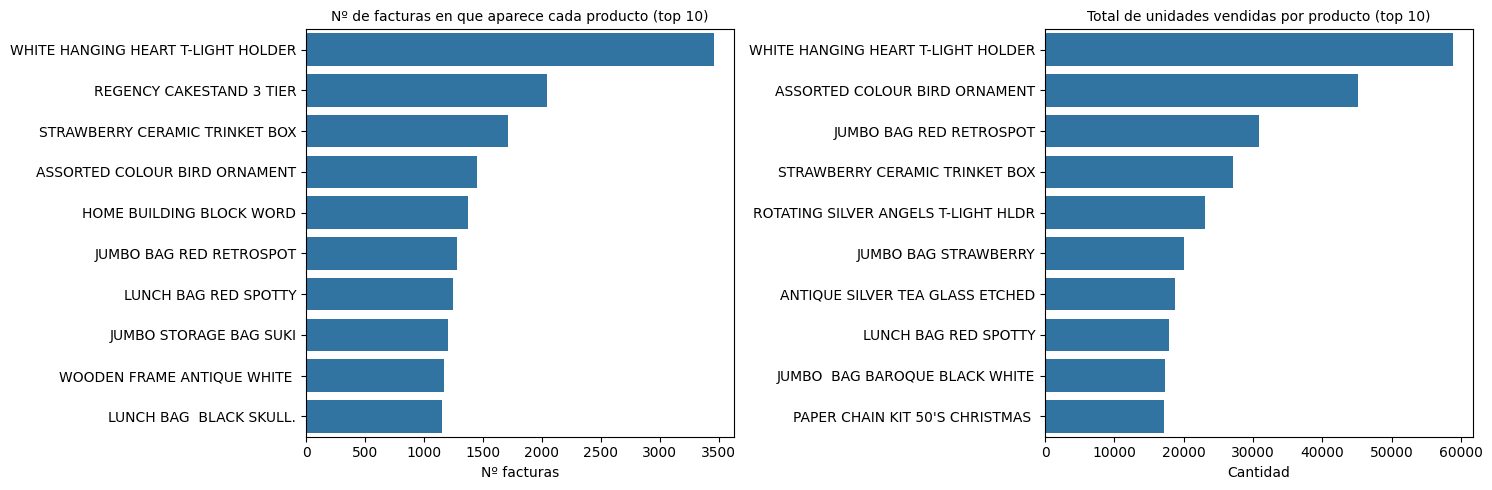

In [14]:
# productos mas vendidos por cantidad y por frecuencia (cantidad de facturas)

df_cantidad = df.groupby("Description")["Quantity"].sum().reset_index().sort_values(by = "Quantity", ascending = False )
df_frecuencia = df.groupby("Description")["Invoice"].count().reset_index().sort_values(by = "Invoice", ascending = False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15, 5))

sns.barplot(x = "Invoice", y = "Description", data = df_frecuencia.head(10), ax = axes[0])
sns.barplot(x = "Quantity", y = "Description", data = df_cantidad.head(10), ax = axes[1])

axes[0].set_ylabel("")
axes[1].set_ylabel("")

axes[0].set_xlabel("Nº facturas")
axes[1].set_xlabel("Cantidad")

axes[0].set_title("Nº de facturas en que aparece cada producto (top 10)", fontsize = 10)
axes[1].set_title("Total de unidades vendidas por producto (top 10)",  fontsize = 10)

plt.tight_layout()

**Conclusiones de esta gráfica**

- `WHITE HANGING HEART T-LIGHT HOLDER` lidera en ambas métricas → producto estrella para recomendaciones.

- **No todos los productos coinciden** en ambos tops:

  - Algunos son muy **frecuentes** (aparecen en muchas cestas), pero se venden en pocas unidades → ideales para promociones cruzadas.

  - Otros tienen **mucho volumen**, pero aparecen en menos tickets → pueden ser compras masivas o por stock.

**¿Qué implicaciones tiene esto para nuestro analisis?**

- Usar los productos más **frecuentes** como base para reglas (`Apriori`, `FP-Growth`).

- Analizar los de **alto volumen** por separado, podrían responder a clientes o eventos distintos.

- Considerar agrupar productos por tipo o categoría para reglas más generalizables.

In [15]:
# ventas por mes y año
# primero convierto a datetime la columna de la fecha de la factura
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# creo una columna nueva con el mes de la compra y el año
df['Month'] = df['InvoiceDate'].dt.month
df['Year'] = df['InvoiceDate'].dt.year


# calculo el nº de facturas por mes
df_ventas_por_mes = df.groupby('Month')['InvoiceDate'].nunique().reset_index()
df_ventas_por_mes.columns = ['Mes', 'Nº de ventas']

df_ventas_por_mes_anyo = df.groupby(['Year', 'Month'])['InvoiceDate'].nunique().reset_index()
df_ventas_por_mes_anyo.columns = ['Año', 'Mes', 'Nº de ventas']

df_ventas_por_mes.head()

,Mes,Nº de ventas
0,1,1034
1,2,1115
2,3,1527
3,4,1334
4,5,1364


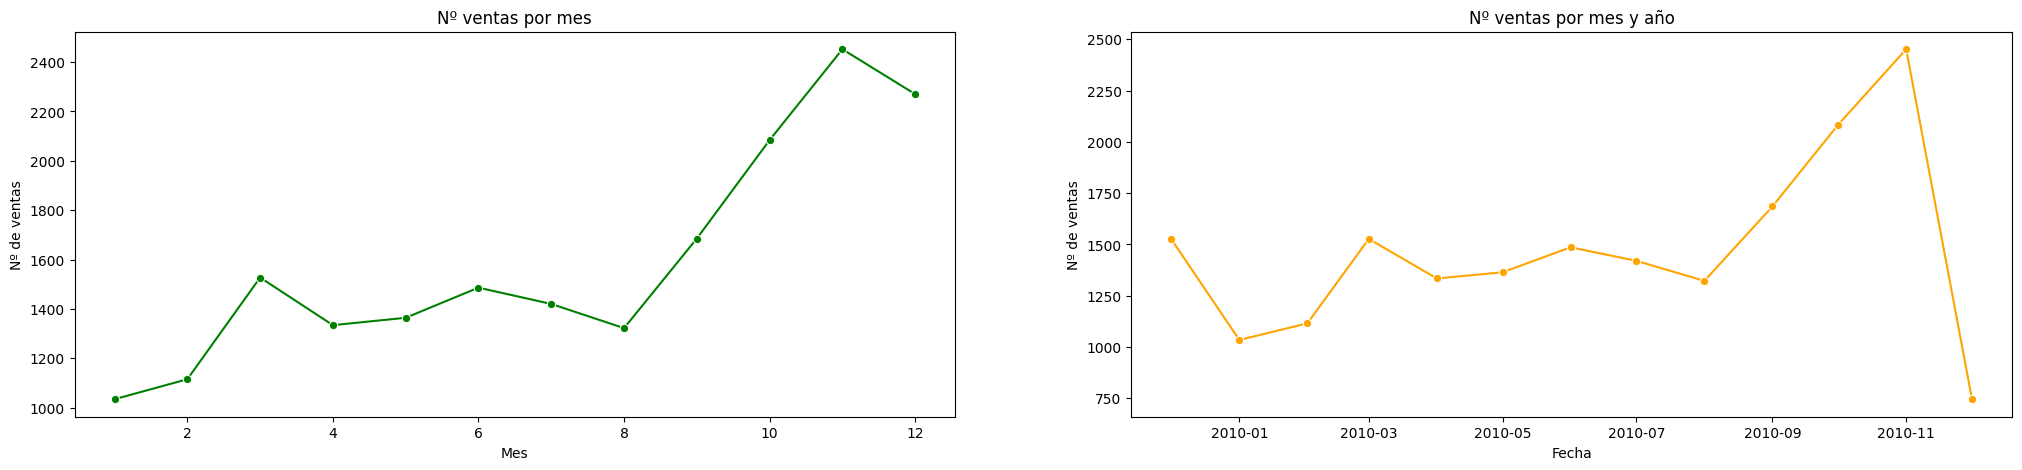

In [16]:
# ventas por mes y por mes y año
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (25, 5))
# ventas por mes
sns.lineplot(x = "Mes", 
             y = "Nº de ventas", 
             data = df_ventas_por_mes, 
             marker = "o",
             ax = axes[0], 
             color = "green")


# ventas por mes y año
df_ventas_por_mes_anyo['Fecha'] = pd.to_datetime({
    'year': df_ventas_por_mes_anyo['Año'],
    'month': df_ventas_por_mes_anyo['Mes'],
    'day': 1  # Día fijo para construir la fecha
})

sns.lineplot(data=df_ventas_por_mes_anyo, 
             x='Fecha', 
             y='Nº de ventas',
             marker='o', 
             ax = axes[1], 
             color = "orange")

axes[0].set_title("Nº ventas por mes")
axes[1].set_title("Nº ventas por mes y año");
 

**Conclusiones de las gráficas**

- Ventas por mes:

    - Se observa una **tendencia creciente a lo largo del año**, con un **pico de ventas en noviembre y diciembre**. Esto sugiere una fuerte estacionalidad, siendo los ultimos meses los que concentran la mayoria de las ventas. Además, se puede observar que noviembre destaca como el mes clave, probablemente por **Black Friday** o anticipación navideña.

    - El volumen de ventas es más bajo entre enero y agosto, con un leve repunte en marzo y junio.


    **¿Como puede afectar esto al basket analysis**

    - Las reglas de asociación pueden **variar según la temporada**.
    
    - Recomendable segmentar el análisis por **trimestres o estaciones del año**.
    
    - Entrenar modelos específicos para **octubre, noviembre y diciembre** permitirá generar recomendaciones más relevantes.

- Ventas por mes y año

    - Confirma el patrón del gráfico anterior: **crecimiento sostenido** hasta un máximo en **noviembre 2010**. Reforzando que las **campañas de ventas fuertes empiezan en octubre** y se disparan en noviembre.

    - La caída en diciembre podría deberse a que los datos de ese mes están incompletos o cortados.

    **¿Como puede afectar esto al basket analysis**

    - Entrenar el algoritmo solo con datos de noviembre puede ayudar a encontrar **reglas específicas de la temporada alta**.


In [17]:
df.head(2)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Month,Year
131147,501854,M,MANUAL,3,2010-03-21 11:15:00,1.0,15446.0,United Kingdom,3,2010
103829,499297,NaN,WAY OUT METAL SIGN,288,2010-02-25 20:16:00,1.0,18102.0,United Kingdom,2,2010


Hay un total de 20523 facturas


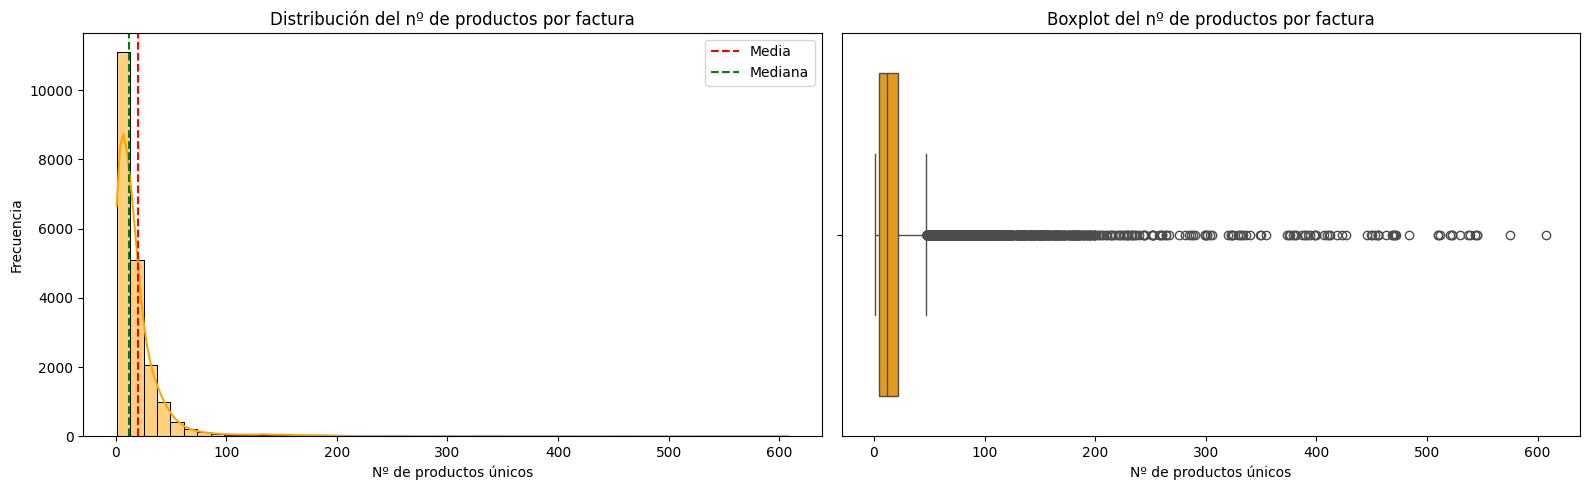

In [18]:
# nº de productos por factura
df_productos_factura = df.groupby("Invoice")["Description"].nunique().reset_index().sort_values(by = "Description", ascending = False)
df_productos_factura.rename(columns = {"Description": "Nº productos"}, inplace = True)
df_productos_factura["Invoice"] = df_productos_factura["Invoice"].astype(str)

print(f"Hay un total de {df_productos_factura.shape[0]} facturas")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

sns.histplot(df_productos_factura["Nº productos"], 
             bins=50, 
             kde=True, 
             color="orange", 
             ax=axes[0])

axes[0].axvline(df_productos_factura["Nº productos"].mean(), 
                color='red', 
                linestyle='--', 
                label='Media')

axes[0].axvline(df_productos_factura["Nº productos"].median(), 
                color='green', 
                linestyle='--', 
                label='Mediana')

axes[0].set_title("Distribución del nº de productos por factura")
axes[0].set_xlabel("Nº de productos únicos")
axes[0].set_ylabel("Frecuencia")
axes[0].legend()


sns.boxplot(x=df_productos_factura["Nº productos"], 
            color="orange", 
            ax=axes[1])

axes[1].set_title("Boxplot del nº de productos por factura")
axes[1].set_xlabel("Nº de productos únicos")

plt.tight_layout();


**Conclusiones de estas gráficas**

- La mayoría de las facturas contienen entre **5 y 25 productos únicos**.

- La **media (~20)** está muy por encima de la **mediana (~12)**, lo que refleja la presencia de **outliers a la derecha** (facturas muy grandes, con muchos productos).

- Las gráficas muestran una fuerte **asimetría positiva** (sesgo a la derecha), típica en retail.

**¿Cómo afecta al análisis?**

- Las **transacciones más pequeñas** son las más comunes y deben usarse como base para aprender reglas frecuentes y valiosas.

- Las **facturas muy grandes** (más de 50 productos) pueden distorsionar las métricas y producir reglas poco útiles.

- Recomendable **segmentar las reglas** por tamaño de cesta (pequeña, media, grande).

- Se podrían **entrenar modelos distintos** para clientes finales vs. mayoristas si se detecta este patrón.


<span style="color:orange; font-size:20px">A la vista de estos resultados voy a filtrar por percentiles y segmentar las transacciones según el tamaño de la cesta</span>

In [20]:
# Calculamos los percentiles y clasificamos las transacciones

# calculo los percentiles
p25 = df_productos_factura["Nº productos"].quantile(0.25)
p75 = df_productos_factura["Nº productos"].quantile(0.75)
p95 = df_productos_factura["Nº productos"].quantile(0.95)

df_productos_factura["Tamaño cesta"] = df_productos_factura["Nº productos"].apply(lambda x: se.clasificar_cesta(x, p25, p75, p95))
df_productos_factura.sample(2)

,Invoice,Nº productos,Tamaño cesta
3774,499175,6,Media
19479,535836,7,Media


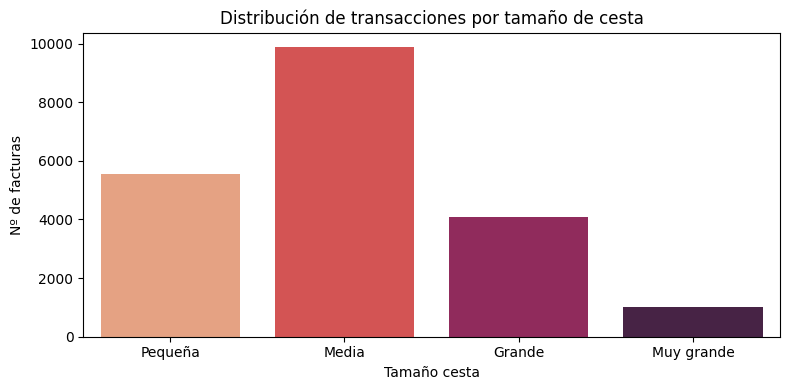

In [22]:
# Conteo por tamaño de cesta
conteo = df_productos_factura["Tamaño cesta"].value_counts().reindex(["Pequeña", "Media", "Grande", "Muy grande"])

# Gráfico de barras
plt.figure(figsize=(8, 4))
sns.barplot(x=conteo.index, 
            y=conteo.values, 
            palette="rocket_r", 
            hue = conteo.index, 
            legend = False)
plt.title("Distribución de transacciones por tamaño de cesta")
plt.xlabel("Tamaño cesta")
plt.ylabel("Nº de facturas")
plt.tight_layout()
plt.show()

**¿Cómo interpretamos esta gráfica?**

- Las cestas **medias y pequeñas** representan la **gran mayoría de las transacciones**.

- Las **cestas grandes y muy grandes** son menos frecuentes, pero contienen una gran variedad de productos.

**¿Quéimplicaciones tiene para el analisis?**

- Usar las cestas pequeñas y medias como base para generar reglas robustas y generalizables.

- Las reglas obtenidas de cestas grandes pueden ser útiles para estrategias personalizadas o segmentadas (mayoristas, packs, eventos).

- Recomendable **segmentar los análisis** para evitar que los patrones de grandes transacciones contaminen las reglas generales.

In [25]:
# patrones de precios por regiones, voy a calcular por país:
# Número de facturas (transacciones)
# Número total de productos comprados
# Gasto total (facturación)
# Precio medio por producto o por transacción

# primero voy a calcular el precio total para cada una de las filas 
df["TotalPrice"] = df["Price"] * df["Quantity"]
df.sample(3)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Month,Year,TotalPrice
49201,493981,NaN,FELTCRAFT 6 FLOWER FRIENDS,40,2010-01-10 12:06:00,1.85,14160.0,United Kingdom,1,2010,74.0
144875,503180,84931B,BLUE SCOTTIE DOG W FLOWER PATTERN,2,2010-03-30 14:14:00,2.55,12836.0,United Kingdom,3,2010,5.1
385753,526430,NaN,POPPY'S PLAYHOUSE BEDROOM,6,2010-10-11 15:12:00,2.10,17635.0,United Kingdom,10,2010,12.6


In [32]:
# creo todas las agrupaciones para mi objetivo
df_por_pais = df.groupby("Country").agg(
    N_facturas=("Invoice", "nunique"),
    N_productos=("Quantity", "sum"),
    Total_facturado=("TotalPrice", "sum")
).reset_index()

# calculo el precio medio por producto
df_por_pais["Precio_medio_producto"] = df_por_pais["Total_facturado"] / df_por_pais["N_productos"]

# calculo el precio medio por transaccion
df_por_pais["Gasto_medio_factura"] = df_por_pais["Total_facturado"] / df_por_pais["N_facturas"]
df_por_pais.head()

,Country,N_facturas,N_productos,Total_facturado,Precio_medio_producto,Gasto_medio_factura
0,Australia,40,10680,27007.00,2.528745,675.175000
1,Austria,28,4140,11897.89,2.873886,424.924643
2,Bahrain,7,811,2211.55,2.726942,315.935714
3,Belgium,51,6805,21447.60,3.151741,420.541176
4,Bermuda,1,234,639.10,2.731197,639.100000


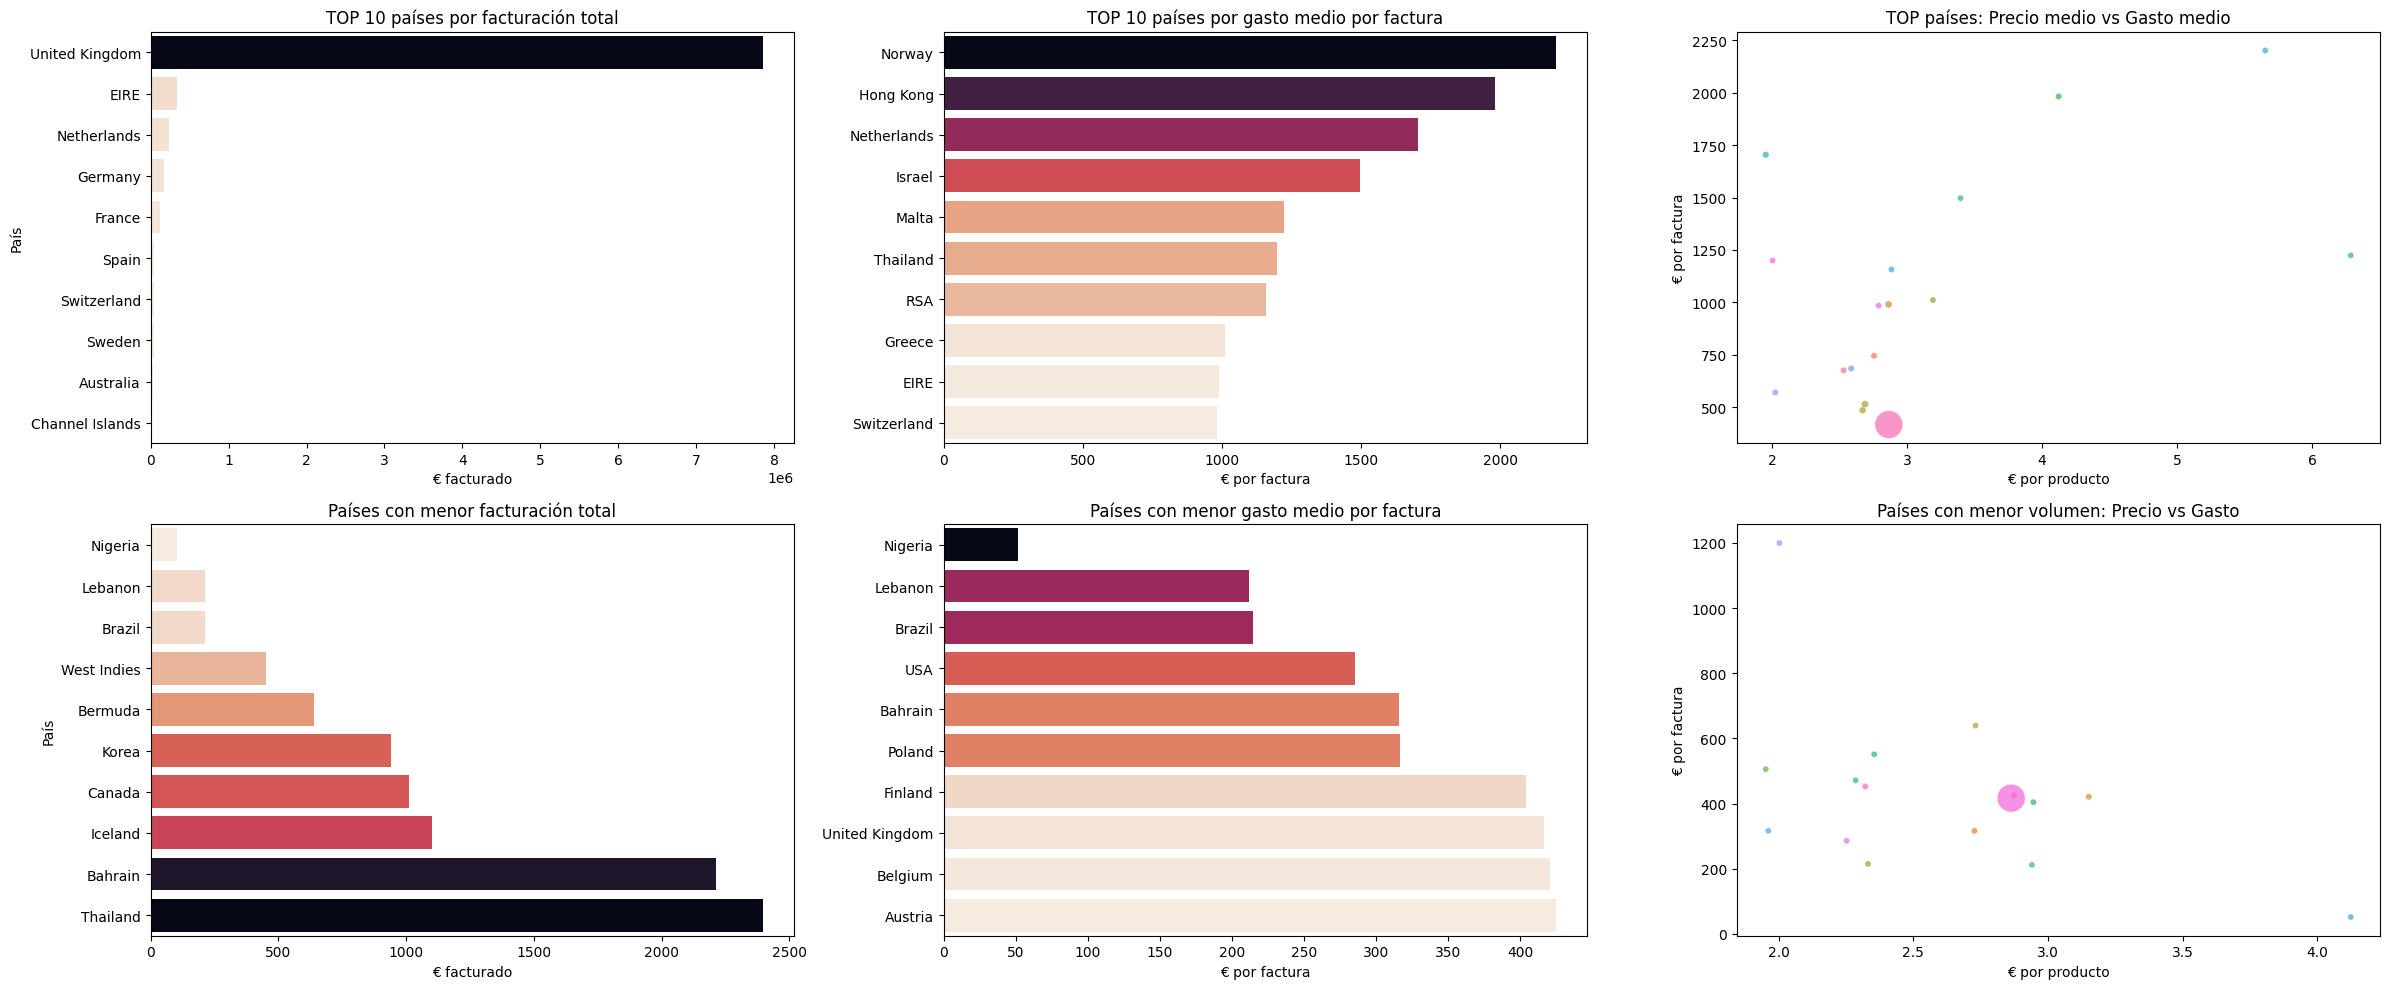

In [39]:
# seleccionamos los paises con mas y menos ventas
top_facturacion = df_por_pais.sort_values("Total_facturado", ascending=False).head(10)
top_gasto_medio = df_por_pais.sort_values("Gasto_medio_factura", ascending=False).head(10)

bottom_facturacion = df_por_pais.sort_values("Total_facturado", ascending=True).head(10)
bottom_gasto_medio = df_por_pais.sort_values("Gasto_medio_factura", ascending=True).head(10)


# Crear figura con 2x3 subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24, 10))

# --- TOP PAISES ---
sns.barplot(y="Country", 
            x="Total_facturado", 
            data=top_facturacion, 
            palette="rocket_r", 
            hue = "Total_facturado", 
            legend = False,
            ax=axes[0, 0])

axes[0, 0].set_title("TOP 10 países por facturación total")
axes[0, 0].set_xlabel("€ facturado")
axes[0, 0].set_ylabel("País")

sns.barplot(y="Country", 
            x="Gasto_medio_factura", 
            data=top_gasto_medio, 
            palette="rocket_r", 
            hue = "Gasto_medio_factura", 
            legend = False,
            ax=axes[0, 1])

axes[0, 1].set_title("TOP 10 países por gasto medio por factura")
axes[0, 1].set_xlabel("€ por factura")
axes[0, 1].set_ylabel("")

sns.scatterplot(
    x="Precio_medio_producto", 
    y="Gasto_medio_factura", 
    data=df_por_pais[df_por_pais["Country"].isin(top_facturacion["Country"]) | 
                     df_por_pais["Country"].isin(top_gasto_medio["Country"])],
    size="N_facturas", 
    hue="Country",
    sizes=(20, 400),
    alpha=0.7,
    ax=axes[0, 2],
    legend=False
)
axes[0, 2].set_title("TOP países: Precio medio vs Gasto medio")
axes[0, 2].set_xlabel("€ por producto")
axes[0, 2].set_ylabel("€ por factura")

# --- BOTTOM PAISES ---
sns.barplot(y="Country", 
            x="Total_facturado", 
            data=bottom_facturacion, 
            palette="rocket_r", 
            hue = "Total_facturado", 
            legend = False,
            ax=axes[1, 0])


axes[1, 0].set_title("Países con menor facturación total")
axes[1, 0].set_xlabel("€ facturado")
axes[1, 0].set_ylabel("País")

sns.barplot(y="Country", 
            x="Gasto_medio_factura", 
            data=bottom_gasto_medio, 
            palette="rocket", 
            hue = "Gasto_medio_factura", 
            legend = False,
            ax=axes[1, 1])

axes[1, 1].set_title("Países con menor gasto medio por factura")
axes[1, 1].set_xlabel("€ por factura")
axes[1, 1].set_ylabel("")

sns.scatterplot(
    x="Precio_medio_producto", 
    y="Gasto_medio_factura", 
    data=df_por_pais[df_por_pais["Country"].isin(bottom_facturacion["Country"]) | 
                     df_por_pais["Country"].isin(bottom_gasto_medio["Country"])],
    size="N_facturas", 
    hue="Country",
    sizes=(20, 400),
    alpha=0.7,
    ax=axes[1, 2],
    legend=False
)
axes[1, 2].set_title("Países con menor volumen: Precio vs Gasto")
axes[1, 2].set_xlabel("€ por producto")
axes[1, 2].set_ylabel("€ por factura")

# Ajustar todo el layout
plt.tight_layout()
plt.show()

**Conclusiones de las gráficas**


- **Países con mayor volumen y gasto**

    - **Reino Unido** lidera con una enorme diferencia en facturación. Es el mercado dominante y, por tanto, **el más relevante para extraer reglas frecuentes** de *basket analysis*.

    - Otros países como **EIRE, Alemania, Francia o España** también aparecen en el ranking por volumen, pero con mucha menor representación.

    - En cuanto a **gasto medio por factura**, destacan países como **Noruega, Hong Kong o Israel**, que no tienen tanto volumen, pero sí transacciones de alto valor → podrían representar un **segmento premium**.
 
    > Es útil entrenar modelos separados para Reino Unido (gran volumen) y para países de alto ticket medio (segmento lujo o clientes de alto valor).

- **Países con menor volumen de compras**

    - Algunos países como **Nigeria, Líbano o Brasil** tienen tanto una baja facturación como un bajo gasto medio.

    - Estos casos pueden reflejar:

        - Mercados en los que apenas se ha entrado.

        - Transacciones puntuales.

        - Clientes con patrones muy distintos (o datos residuales).


    > Estos países podrían **introducir ruido** si se incluyen en el análisis general. Es recomendable:
        > - Agruparlos como "Otros".
        > - Analizarlos por separado si hay interés comercial en potenciar esos mercados.


- **Relación entre precio medio y gasto medio**

    - Algunos países tienen un precio medio bajo pero alto gasto total → **compran mucho, aunque barato** (carritos grandes).

    - Otros muestran precio alto pero gasto moderado → podrían estar comprando productos de gama alta pero en pequeñas cantidades.


    > Puedes usar esta relación para definir **segmentos estratégicos**:
        > - Clientes **intensivos**: muchos productos a bajo precio (packs, mayoristas).
        > - Clientes **selectivos**: productos caros, poco volumen (lujo, decoración, regalos).


# Conclusiones

A la vitsa de todos estos resultaos, tendre que:

- `Paso 0: Gestión de valores nulos`: Antes de cualquier transformación, es fundamental que revise y trate los valores nulos para asegurar la calidad del análisis. En este paso:

    - Gestionare los valores nulos en cualquiera de estas columnas, ya que son esenciales para el análisis de cesta.


- `Paso 1: Filtrado por país`: Dado que algunos países tienen muy poca actividad, puedo:

    - Trabajar exclusivamente con un país principal (por ejemplo, United Kingdom) para asegurar volumen y calidad de reglas.

    - O bien, conservar solo los países con un número mínimo de transacciones, y excluir los de bajo volumen para evitar ruido.


- `Paso 2: Transformación a formato “basket”`: Convertir el dataset de formato transaccional (varias filas por factura) a una **matriz de facturas vs. productos**, donde cada celda representa la cantidad total de un producto en una transacción.


- `Paso 3: Binarización`: Para aplicar modelos como Apriori, necesito una matriz binaria. Por tanto, convertiré la presencia de productos en cada transacción a 1 (presente) o 0 (ausente), sin importar la cantidad.


- `Paso 4: Filtrado de productos poco frecuentes`: Para reducir ruido y mejorar la eficiencia del modelo, es recomendable eliminar los productos que aparecen en muy pocas facturas. Esto ayudará a centrar el análisis en productos relevantes y frecuentes.

In [40]:
df.to_csv("../data/retail_limpio.csv")